In [1]:
import spacy
sp = spacy.load('en')

In [2]:
import re
import os
import random
import csv
import json
import multiprocessing
import datetime
from pprint import pprint
from collections import Counter, defaultdict
from collections.abc import Sequence
from operator import itemgetter

import numpy
import scipy
import pandas
import nearpy
from Levenshtein import distance as lev_distance
from scipy import signal

from lextrie import LexTrie

import matplotlib
%matplotlib inline

In [3]:
### Script Settings ###

# Modify these to change input files and other parameters.

# Input filenames:
home_folder = '../../../../'
original_script_filename = os.path.join(
    home_folder, 
    'original-scripts/force-awakens/force-awakens-lines.csv'
)
original_script_markup = os.path.join(
    home_folder,
    'original-scripts/force-awakens/force-awakens-markup.txt'
)
fan_work_directory = os.path.join(
    home_folder, 
    'fan-works/force-awakens-fullset/plaintext'
)

# Set N-Gram window size:
window_size = 10
window_size = 6

# Set cosine distance matching threshold:
distance_threshold = 0.25
distance_threshold = 0.1

# Set approximate nearest neighbor parameters:
number_of_hashes = 15  # Bigger -> slower (linear), more matches
hash_dimensions = 14   # Bigger -> faster (???), fewer matches

new_record_structure = {
    'fields': ['FAN_WORK_FILENAME', 
               'FAN_WORK_WORD_INDEX', 
               'FAN_WORK_WORD',
               'FAN_WORK_ORTH_ID',
               'ORIGINAL_SCRIPT_WORD_INDEX',
               'ORIGINAL_SCRIPT_WORD',
               'ORIGINAL_SCRIPT_ORTH_ID',
               'ORIGINAL_SCRIPT_CHARACTER',
               'ORIGINAL_SCRIPT_SCENE',
               'BEST_MATCH_DISTANCE',
               'BEST_LEVENSHTEIN_DISTANCE',
               'BEST_COMBINED_DISTANCE', 
               #'ANGER',
               #'ANTICIPATION',
               #'DISGUST',
               #'FEAR',
               #'JOY',
               #'SADNESS',
               #'SURPRISE',
               #'TRUST',
               #'NEGATIVE',
               #'POSITIVE'
              ],
    'types': [str, int, str, int, int, str, 
              int, str, int, float, int, float, 
              #int, int, int, int, int,
              #int, int, int, int, int
             ]
}

In [38]:
# Utility functions

def mk_vectors(sp_txt):
    """Given a parsed text in `spacy`'s native format, produce
    a sequence of vectors, one per token.
    """
    rows = len(sp_txt)
    cols = len(sp_txt[0].vector) if rows else 0
    vectors = numpy.empty((rows, cols), dtype=float)
    for i, word in enumerate(sp_txt):
        if word.has_vector:
            vectors[i] = word.vector
        else:
            # It seems `spacy` doesn't have a pre-trained vector for
            # this word. So we do something pretty dumb here to give
            # the word a vector that is unique to that word and not
            # too similar to other words.
            w_str = str(word)
            vectors[i] = 0
            vectors[i][hash(w_str) % cols] = 1.0
            vectors[i][hash(w_str * 2) % cols] = 1.0
            vectors[i][hash(w_str * 3) % cols] = 1.0
    return vectors

def cosine_distance(row_values, col_values):
    """Calculate the cosine distance between two vectors. Also
    accepts matrices and 2-d arrays, and calculates the 
    distances over the cross product of rows and columns.
    """
    verr_msg = '`cosine_distance` is not defined for {}-dimensional arrays.'
    if len(row_values.shape) == 1:
        row_values = row_values[None,:]
    elif len(row_values.shape) != 2:
        raise ValueError(verr_msg.format(len(row_values.shape)))
    
    if len(col_values.shape) == 1:
        col_values = col_values[:,None]
    elif len(col_values.shape) != 2:
        raise ValueError(verr_msg.format(len(col_values.shape)))

    row_norm = (row_values * row_values).sum(axis=1) ** 0.5
    row_norm = row_norm[:,None]
    
    col_norm = (col_values * col_values).sum(axis=0) ** 0.5
    col_norm = col_norm[None,:]

    result = row_values @ col_values
    result /= row_norm
    result /= col_norm
    return 1 - result

# TODO: Allow windows to be built over non-contiguous portions of text,
#       (to allow dropping of punctuation, etc) while preserving index
#       information for each word. This will require including a new
#       parameter that provides the correct index for each word in orig
# TODO: Allow input to be pre-parsed using spacy. This will involve 
#       capturing the spacy orth_id and using it to recreate the lexeme
#       and vetor data.
# TODO: Make this function more "format aware." It will simplify things
#       to accept more coupling here. This is a function for processing
#       scripts in exactly one format.
def build_lsh_engine(orig, window_size, number_of_hashes, hash_dimensions):
    # Build the ngram vectors using rolling windows. 
    # Variables named `*_win_vectors` contain vectors for
    # the given input, such that each row is the vector
    # for a single window. Successive windows overlap
    # at all words except for the first and last.
    orig_vectors = mk_vectors(orig)
    orig_win_vectors = numpy.array([orig_vectors[i:i + window_size, :].ravel()
                                   for i in range(orig_vectors.shape[0] - window_size + 1)])

    # Initialize the approximate nearest neighbor search algorithm.
    # This creates the search "engine" and populates its index with
    # the window-vectors from the original script. We can then pass
    # over the window-vectors from a fan work, taking each vector
    # and searching for good matches in the engine's index of script
    # text.

    # We could do the search in the opposite direction, storing 
    # fan text in the engine's index, and passing over window-
    # vectors from the original script, searching for matches in 
    # the index of fan text. Unfortuantely, the quality of the 
    # matches found goes down when you add too many values to the
    # engine's index.
    vector_dim = orig_win_vectors.shape[1]
    hashes = []
    for i in range(number_of_hashes):
        h = nearpy.hashes.RandomBinaryProjections('rbp{}'.format(i),
                                                  hash_dimensions)
        hashes.append(h)

    engine = nearpy.Engine(vector_dim,
                           lshashes=hashes,
                           distance=nearpy.distances.CosineDistance())
    
    for ix, row in enumerate(orig_win_vectors):
        engine.store_vector(row, (ix, str(orig[ix: ix + window_size])))
    return engine

def find_matches_multi(fan_works, ann_index, pool):
    chunksize = len(fan_works) // (4 * pool._processes)
    record_sets = pool.map(ann_index.search, fan_works, chunksize=chunksize)
    records = []
    records.extend(r for r_set in record_sets for r in r_set)
    return records

class AnnIndexSearch(object):
    def __init__(self, original_script_filename, window_size,
                 number_of_hashes, hash_dimensions, distance_threshold):

        orig_csv = load_markup_script(original_script_filename)
        orig_csv = orig_csv[1:]  # drop header
        orig_csv = [[i] + r for i, r in enumerate(orig_csv)]
        # resulting csv format: 
        # [['ORIGINAL_SCRIPT_INDEX', 
        #   'LOWERCASE', 
        #   'SPACY_ORTH_ID', 
        #   'SCENE',
        #   'CHARACTER']]

        (self.word_index,
         self.word_lowercase, 
         self.orth_id, 
         self.scene, 
         self.character) = zip(*orig_csv)

        self.window_size = window_size
        self.distance_threshold = distance_threshold
        
        orig_doc = spacy.tokens.Doc(sp.vocab, self.word_lowercase)
        self.engine = build_lsh_engine(orig_doc, window_size, 
                                       number_of_hashes, hash_dimensions)
        self.reset_stats()
    
    def reset_stats(self):
        self._windows_processed = 0
        
    @property
    def windows_processed(self):
        return self._windows_processed
    
    def search(self, filename):
        with open(filename) as fan_file:
            fan = sp(fan_file.read())
    
        # Create the fan windows:
        fan_vectors = mk_vectors(fan)
        fan_win_vectors = numpy.array(
            [fan_vectors[i:i + self.window_size, :].ravel()
             for i in range(fan_vectors.shape[0] - self.window_size + 1)]
        )

        duplicate_records = defaultdict(list)
        for fan_ix, row in enumerate(fan_win_vectors):
            self._windows_processed += 1
            results = self.engine.neighbours(row)
            
            # Extract data about the original script
            # embedded in the engine's results.
            results = [(match_ix, match_str, distance) 
                       for vec, (match_ix, match_str), distance in results 
                       if distance < self.distance_threshold]

            # Create a new record with original script 
            # information and fan work information.
            for match_ix, match_str, distance in results:
                fan_context = str(fan[fan_ix: fan_ix + window_size])
                lev_d = lev_distance(match_str, fan_context)
                
                for window_ix in range(window_size):
                    fan_word_ix = fan_ix + window_ix
                    fan_word = fan[fan_word_ix].orth_
                    fan_orth_id = fan[fan_word_ix].orth
                    
                    orig_word_ix = match_ix + window_ix
                    orig_word = self.word_lowercase[orig_word_ix]
                    orig_orth_id = self.orth_id[orig_word_ix]
                    char = self.character[orig_word_ix]
                    scene = self.scene[orig_word_ix]
        
                    duplicate_records[(filename, fan_word_ix)].append(
                        # NOTE: This **must** match the definition 
                        #       of `record_structure` above
                        [filename,
                         fan_word_ix,
                         fan_word,
                         fan_orth_id,
                         orig_word_ix,
                         orig_word,
                         orig_orth_id,
                         char,
                         scene,
                         distance, 
                         lev_d, 
                         distance * lev_d]
                    )
                
        # To deduplicate duplicate_records, we
        # pick the single best match, as measured by 
        # the combined distance for the given n-gram 
        # match that first identified the word.
        for k, dset in duplicate_records.items():
            duplicate_records[k] = min(dset, key=itemgetter(11))

        return sorted(duplicate_records.values())

def make_match_strata(records, record_structure, num_strata, max_threshold):
    combined_ix = record_structure['fields'].index('BEST_COMBINED_DISTANCE')
    low = [i / num_strata * max_threshold 
           for i in range(0, num_strata)]
    high = [i / num_strata * max_threshold 
            for i in range(1, num_strata + 1)]
    ranges = zip(low, high)
    
    return [[r for r in records[1:] 
             if r[combined_ix] >= low and r[combined_ix] < high]
            for low, high in ranges]

def label_match_strata(num_strata, max_threshold):
    high = [i / num_strata * max_threshold 
            for i in range(1, num_strata + 1)]
    return ['Number of matches below threshold {:.2}'.format(h)
            for h in high]

def chart_match_strata(records, 
                       num_strata=5, max_threshold=1, 
                       start=1, end=None, 
                       figsize=(15, 10), 
                       colormap='plasma',
                       legend=True):
    match_strata = make_match_strata(records, new_record_structure, num_strata, max_threshold)

    cumulative_strata = [match_strata[0:i] for i in 
                         range(len(match_strata), 0, -1)]
    match_counters = [Counter(row[4] for matches in strata for row in matches) 
                      for strata in cumulative_strata]
    maxn = max(max(mc) for mc in match_counters if mc)
    match_cols = [[mc[n] for mc in match_counters]
                  for n in range(maxn + 1)]

    col_names = label_match_strata(num_strata, max_threshold)
    col_names.reverse()
    df = pandas.DataFrame(match_cols,
                          index = range(maxn + 1),
                          columns=col_names)
    df.index.name = 'Word index in original script'
    df = df.loc[start:end]
    df.plot(figsize=figsize, colormap=colormap, legend=legend)

def most_frequent_matches(records, n_matches, threshold):
    ct = Counter(r[3] for r in records if r[-1] < threshold)
    ix_to_context = {r[3]: r[4] for r in records}
    matches = ct.most_common(n_matches)
    return [(i, c, ix_to_context[i]) 
            for i, c in ct.most_common(n_matches)]
    return ct.most_common(n_matches)

def load_txt_script(filename):
    with open(filename) as orig_in:
        orig_txt = orig_in.read()
        orig_txt = re.sub(r'\s+', ' ', orig_txt).strip()
        orig = sp(orig_txt)

def load_csv_script(filename):
    with open(filename) as orig_in:
        orig_csv = list(csv.reader(orig_in))[1:]
        orig_txt = ' '.join(line.strip() for char, line in orig_csv)
        tokens = sp(orig_txt)
        
        characters = []
        char_lines = iter(orig_csv)
        char, line = next(char_lines, ('', ''))
        
        start = 0
        for end in range(1, len(tokens)):
            tok_line = str(tokens[start:end])
            if line == tok_line:
                characters.extend([char] * (end - start))
                char, line = next(char_lines, ('', ''))
                start = end            
        return tokens, characters

def load_markup_script(filename,
                        _line_rex=re.compile('LINE<<(?P<line>[^>]*)>>'),
                        _scene_rex=re.compile('SCENE_NUMBER<<(?P<scene>[^>]*)>>'),
                        _char_rex=re.compile('CHARACTER_NAME<<(?P<character>[^>]*)>>')):
    with open(filename, encoding='utf-8') as ip:
        current_scene = None
        current_char = None
        current_line = None
        rows = [['LOWERCASE', 'SPACY_ORTH_ID', 'SCENE', 'CHARACTER']]
        for i, line in enumerate(ip):
            if _scene_rex.search(line):
                current_scene = int(_scene_rex.search(line).group('scene'))
            elif _char_rex.search(line):
                current_char = _char_rex.search(line).group('character')
            elif _line_rex.search(line):
                tokens = sp(_line_rex.search(line).group('line'))
                for t in tokens:
                    # original Spacy lexeme object can be recreated using
                    #     spacy.lexeme.Lexeme(sp.vocab, t.orth)
                    # where `sp = spacy.load('en')`
                    row = [t.lower_, t.lower, current_scene, current_char]
                    rows.append(row)
    return rows
    
def write_records(records, filename):
    with open(filename, 'w', encoding='utf-8') as out:
        wr = csv.writer(out)
        wr.writerows(records)

In [5]:
fan_works = os.listdir(fan_work_directory)
fan_works = [os.path.join(fan_work_directory, f) 
             for f in fan_works]   
random.seed(4815162342)  # This will always generate the same "random" sample.
random.shuffle(fan_works)

cluster_size = 500
start = 0
fan_clusters = [fan_works[i:i + cluster_size] for i in range(start, len(fan_works), cluster_size)]
#fan_clusters = fan_clusters[:1]

filename_base = 'match-{}gram{{}}'.format(window_size)
batch_filename = filename_base.format('-batch-{}.csv')

accumulated_records = [new_record_structure['fields']]
for i, fan_cluster in enumerate(fan_clusters, start=start):
    with multiprocessing.Pool(processes=5) as pool:
        now = float(datetime.datetime.now().strftime("%s"))
        ann_index = AnnIndexSearch(original_script_markup, 
                                   window_size, 
                                   number_of_hashes, 
                                   hash_dimensions,
                                   distance_threshold)
        records = find_matches_multi(fan_cluster, ann_index, pool)
        elapsed = float(datetime.datetime.now().strftime("%s")) - now
        print('time elapsed: {}s'.format(elapsed))
        write_records(records, batch_filename.format(i))
        accumulated_records.extend(records)

i = 0
today_str = '-{:%Y%m%d}.csv'.format(datetime.date.today())
name_check = filename_base.format(today_str)
while os.path.exists(name_check):
    i += 1
    today_str = '-{:%Y%m%d}-{}.csv'.format(datetime.date.today(), i)
    name_check = filename_base.format(today_str)

write_records(accumulated_records, 
              name_check)
    

time elapsed: 1253.0s
time elapsed: 1280.0s
time elapsed: 952.0s
time elapsed: 1492.0s
time elapsed: 1049.0s
time elapsed: 1753.0s
time elapsed: 1438.0s
time elapsed: 1387.0s
time elapsed: 1125.0s
time elapsed: 1052.0s
time elapsed: 1470.0s
time elapsed: 1058.0s
time elapsed: 1050.0s
time elapsed: 1408.0s
time elapsed: 1116.0s
time elapsed: 1146.0s
time elapsed: 991.0s
time elapsed: 911.0s
time elapsed: 1490.0s
time elapsed: 1478.0s
time elapsed: 1214.0s
time elapsed: 1392.0s
time elapsed: 1222.0s
time elapsed: 1686.0s
time elapsed: 955.0s
time elapsed: 1783.0s
time elapsed: 1279.0s
time elapsed: 1714.0s
time elapsed: 1757.0s
time elapsed: 1129.0s
time elapsed: 1369.0s
time elapsed: 1078.0s
time elapsed: 1089.0s
time elapsed: 1317.0s
time elapsed: 1158.0s
time elapsed: 996.0s
time elapsed: 1641.0s
time elapsed: 1167.0s
time elapsed: 1013.0s
time elapsed: 1007.0s


In [41]:
def graph_output(match_data_fn, n_size, start, end):
    with open(match_data_fn) as ip:
        rows = list(csv.reader(ip))
        records = [rows[0]]
        records.extend([[new_record_structure['types'][i](cell) 
                         for i, cell in enumerate(row)]
                        for row in rows[1:]])

    print()
    print('Matches from 20k works of fan fiction, '
          'found using 6-gram search'.format(n_size))
    print('(matches counted at the word level)')
    print()
    print('Vertical: number of matches at index (deduplicated)')
    print('Horizontal: index of word in original script')
    chart_match_strata(records, 5, 0.1, start, end, figsize=(15, 5))


Matches from 20k works of fan fiction, found using 6-gram search
(matches counted at the word level)

Vertical: number of matches at index (deduplicated)
Horizontal: index of word in original script


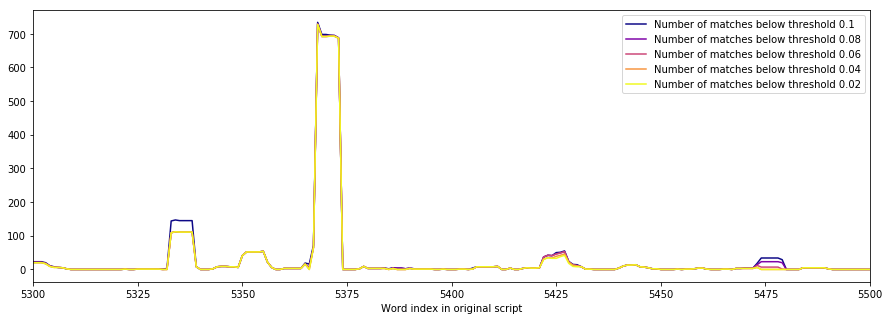

In [58]:
graph_output('match-6gram-20170614.csv', 6, 5300, 5500)


Matches from 20k works of fan fiction, found using 6-gram search
(matches counted at the word level)

Vertical: number of matches at index (deduplicated)
Horizontal: index of word in original script


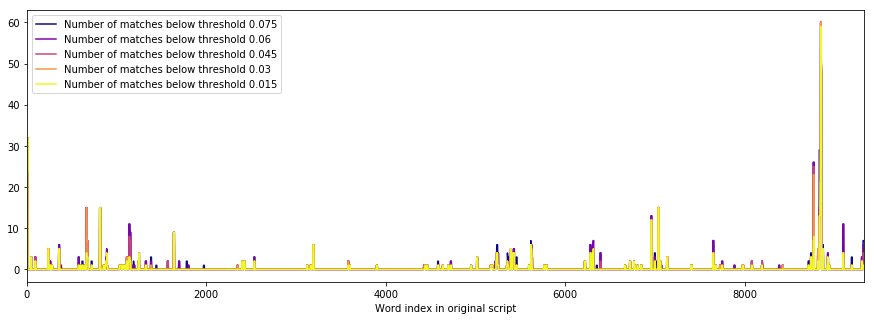

In [23]:
graph_output('match-20k-10gram-wordlevel-20170406.csv', 10)

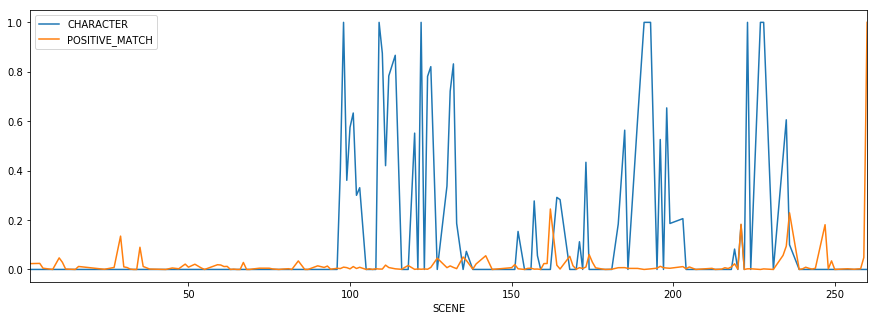

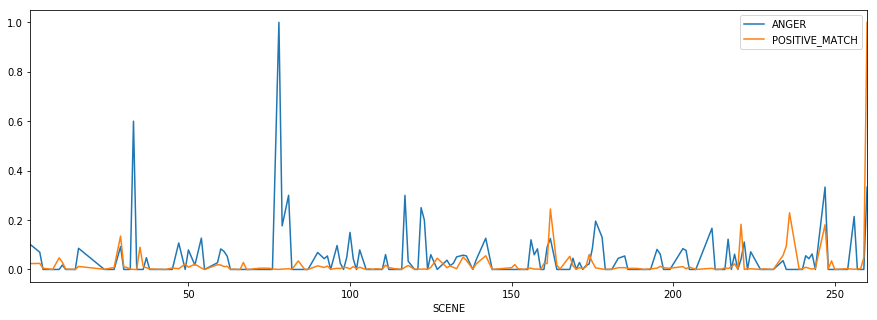

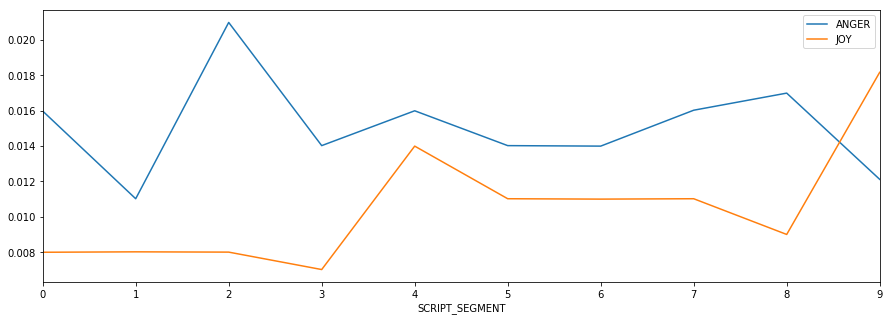

In [61]:
matches = pandas.read_csv('match-6gram-20170614.csv')
positive_match = matches.BEST_COMBINED_DISTANCE < 0.02
matches_thresh = matches.assign(POSITIVE_MATCH=positive_match)

os_markup_raw = load_markup_script(original_script_markup)
os_markup_header = os_markup_raw[0]
os_markup_raw = os_markup_raw[1:]

lt = LexTrie.from_plugin('emolex_en')
emo_terms = ['ANGER',
             'ANTICIPATION',
             'DISGUST',
             'FEAR',
             'JOY',
             'SADNESS',
             'SURPRISE',
             'TRUST',
             'NEGATIVE',
             'POSITIVE']

pos_terms = ['ANTICIPATION',
             'JOY',
             'SURPRISE',
             'TRUST']

os_markup_header.extend(emo_terms)
for r in os_markup_raw:
    emos = lt.get_lex_tags(r[0])
    r.extend(int(t in emos) for t in emo_terms)

os_markup = pandas.DataFrame(os_markup_raw, columns=os_markup_header)
os_markup.index.name = 'ORIGINAL_SCRIPT_WORD_INDEX'

match_word_counts = matches_thresh.groupby(
    'ORIGINAL_SCRIPT_WORD_INDEX'
).aggregate({
    'POSITIVE_MATCH': numpy.sum,
})

match_word_counts = match_word_counts.reindex(
    os_markup.index,
    fill_value=0
)

match_word_words = matches_thresh.groupby(
    'ORIGINAL_SCRIPT_WORD_INDEX'
).aggregate({
    'ORIGINAL_SCRIPT_WORD': numpy.max,
})

match_word_counts = match_word_counts.join(match_word_words)

match_count = match_word_counts.join(os_markup)
# match_count.to_csv('match-20k-10gram-script-count-20170406.csv')

segments = match_count.groupby('SCENE')

char = 'HAN'
charmax = segments.aggregate({'CHARACTER': lambda x: (x == char).mean()}).CHARACTER.max()
angermax = segments.aggregate({'ANGER': numpy.mean}).ANGER.max()
matchmax = segments.aggregate({'POSITIVE_MATCH': numpy.mean}).POSITIVE_MATCH.max()

segments.aggregate({
    'CHARACTER': lambda x: (x == char).mean() / charmax,
    'POSITIVE_MATCH': lambda x: numpy.mean(x) / matchmax
}).plot(figsize=(15, 5))

segments.aggregate({
    'ANGER': lambda x: numpy.mean(x) / angermax,
    'POSITIVE_MATCH': lambda x: numpy.mean(x) / matchmax
}).plot(figsize=(15, 5))

even_segments = match_count.assign(
    SCRIPT_SEGMENT=numpy.round(match_count.index / 1000)
).groupby(
    'SCRIPT_SEGMENT'
)

even_segments.aggregate({
    'ANGER': numpy.mean,
    'JOY': numpy.mean
}).plot(figsize=(15, 5))

In [65]:
best_matches = match_count[match_count.POSITIVE_MATCH > 500]
best_matches

,POSITIVE_MATCH,ORIGINAL_SCRIPT_WORD,LOWERCASE,SPACY_ORTH_ID,SCENE,CHARACTER,ANGER,ANTICIPATION,DISGUST,FEAR,JOY,SADNESS,SURPRISE,TRUST,NEGATIVE,POSITIVE
ORIGINAL_SCRIPT_WORD_INDEX,,,,,,,,,,,,,,,,
603,543.0,the,the,501,29,KYLO REN,0,0,0,0,0,0,0,0,0,0
604,542.0,best,best,902,29,KYLO REN,0,0,0,0,0,0,0,0,0,0
605,541.0,pilot,pilot,7691,29,KYLO REN,0,0,0,0,0,0,0,1,0,1
606,539.0,in,in,522,29,KYLO REN,0,0,0,0,0,0,0,0,0,0
607,539.0,the,the,501,29,KYLO REN,0,0,0,0,0,0,0,0,0,0
608,535.0,resistance,resistance,6705,29,KYLO REN,1,0,0,0,0,0,0,0,1,0
5368,728.0,what,what,594,136,REY,0,0,0,0,0,0,0,0,0,0
5369,734.0,are,are,534,136,REY,0,0,0,0,0,0,0,0,0,0
5370,734.0,you,you,520,136,REY,0,0,0,0,0,0,0,0,0,0


In [57]:
even_segments = match_count.assign(
    SCRIPT_SEGMENT=numpy.round(match_count.index / 10)
).groupby(
    'SCRIPT_SEGMENT'
).aggregate({
    'POSITIVE_MATCH': lambda x: numpy.sum(x),
    'ORIGINAL_SCRIPT_WORD': lambda x: ' '.join(map(str, x))
})
even_segments.loc[500:600]

,POSITIVE_MATCH,ORIGINAL_SCRIPT_WORD
SCRIPT_SEGMENT,,
500.0,245.0,what you started . a map to skywalker himself ...
501.0,511.0,"'re right back in the mess . maz ,"
502.0,1042.0,i need you to get this droid to leia . hmm
503.0,52.0,. no . you 've been running away from
504.0,65.0,"this fight for too long . han , nyakee nago wadda"
505.0,170.0,. go home ! leia does n't want to
506.0,126.0,"see me . please , we came here for your help"
507.0,24.0,. what nan ? the only fight : against
508.0,95.0,"the dark side . through the ages , i 've seen"
